## Image Segmentation

In [21]:
# import libraries
import mxnet as mx
import gluoncv as gcv
import matplotlib.pyplot as plt

from mxnet.gluon.data.vision import transforms
from gluoncv.data.ade20k.segmentation import ADE20KSegmentation
from gluoncv.utils.viz import get_color_pallete

In [2]:
# download image
image_url = 'https://raw.githubusercontent.com/zhreshold/mxnet-ssd/master/data/demo/dog.jpg'
image_filepath = 'dog.jpg'
gcv.utils.download(url=image_url, path=image_filepath)

'dog.jpg'

In [3]:
# load image
image = mx.image.imread(image_filepath)
print('shape:', image.shape)
print('data type:', image.dtype)
print('minimum value:', image.min().asscalar())
print('maximum value:', image.max().asscalar())

('shape:', (576, 768, 3))
('data type:', <type 'numpy.uint8'>)
('minimum value:', 0)
('maximum value:', 255)


In [4]:
# Visual image
#plt.imshow(image);

In [5]:
# custom transform image no pre-set transformation for the data or model we plan to use
transform_fn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
    ])

We using two transforms, ToTensor and Normalize, and they're applied one after another. Using ToTensor, the data layer of the image will be converted from HWC to CHW. The datatype will be converted from an 8-bit integer to a 32-bit float. The method called normalize will normalize the values of the image using the ImageNet one case statistics. 

In [6]:
image = transform_fn(image)
print('shape:', image.shape)
print('data type:', image.dtype)
print('minimum value:', image.min().asscalar())
print('maximum value:', image.max().asscalar())

('shape:', (3, 576, 768))
('data type:', <type 'numpy.float32'>)
('minimum value:', -2.117904)
('maximum value:', 2.64)


In [7]:
# create a batch from a single image
image = image.expand_dims(0)
print(image.shape)

(1, 3, 576, 768)


We use the FCN network with a resonant 50 backbone that's been trained on the ADE20K data set.

In [8]:
# load pre-trained model 
network = gcv.model_zoo.get_model('fcn_resnet50_ade', pretrained=True)

In [9]:
# preduction (Output is a single mxnet.ndarray)
output = network.demo(image)
print(output.shape)

(1, 150, 576, 768)


/Users/chrisjcc/virtualenvs/ml/lib/python2.7/site-packages/gluoncv/model_zoo/segbase.py:92: UserWarning: demo method will be deprecated in favor of predict.
  warnings.warn('demo method will be deprecated in favor of predict.')


In [10]:
# output is a batch
output = output[0] # slash off batch dimension
print(output.shape) # 150 channels (number of classes in the ADE20K dataset)

(150, 576, 768)


All the values in the array are Logits, so we still need to process the outputs to obtain probabilities. We don't want to apply the softmax to all of these values at once though. We want to do this independently for all pixels so that each pixel has a predicted probability distribution across classes

In [11]:
# pixel slice
px_height, px_width = 300, 500 # coordinates of pixel where the origin is located top-left of the image

In [12]:
px_logit = output[:, px_height, px_width] # CHW FORMAT

In [13]:
# use softmax function to convert logits to probabilities
px_probability = mx.nd.softmax(px_logit)
px_rounded_probability = mx.nd.round(px_probability*100)/100
print(px_rounded_probability)


[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.96 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
<NDArray 150 @cpu(0)>


We can see the probability distribution across classes for this particular pixel. One of the highest probabilities is towards the end with a probability of 96%.

In [14]:
# with the argmax function to find the most likely class for this pixel
class_index = mx.nd.argmax(px_logit, axis=0)
class_index = class_index[0].astype('int').asscalar()
print(class_index)

127


In [15]:
class_label = ADE20KSegmentation.CLASSES[class_index] # lookup table from class index to class labels
print(class_label)

bicycle, bike, wheel, cycle


We find that the most likely class for the selected pixel is bike. We know our image contains a bike near the center.

In [16]:
output_proba = mx.nd.softmax(output, axis=0)

Specifying axis equals 0, we can apply softmax independently for all pixels. Axis zero corresponds to the channel dimension which are the classes. So the output is a probability distribution across classes for every pixel. 

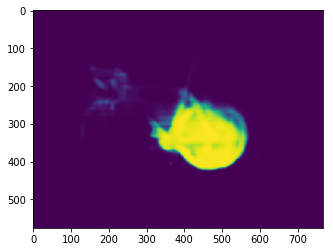

In [18]:
output_heatmap = output_proba[127]
plt.imshow(output_heatmap.asnumpy()); # image of bike

In [19]:
# Visualize most likely class for every pixel
prediction = mx.nd.argmax(output, 0).asnumpy()
print(prediction.shape)

(576, 768)


In [20]:
print(prediction)

[[0. 0. 0. ... 4. 4. 4.]
 [0. 0. 0. ... 4. 4. 4.]
 [0. 0. 0. ... 4. 4. 4.]
 ...
 [3. 3. 3. ... 0. 0. 0.]
 [3. 3. 3. ... 0. 0. 0.]
 [3. 3. 3. ... 0. 0. 0.]]


We interpreted the network outputs and visualize the segments.

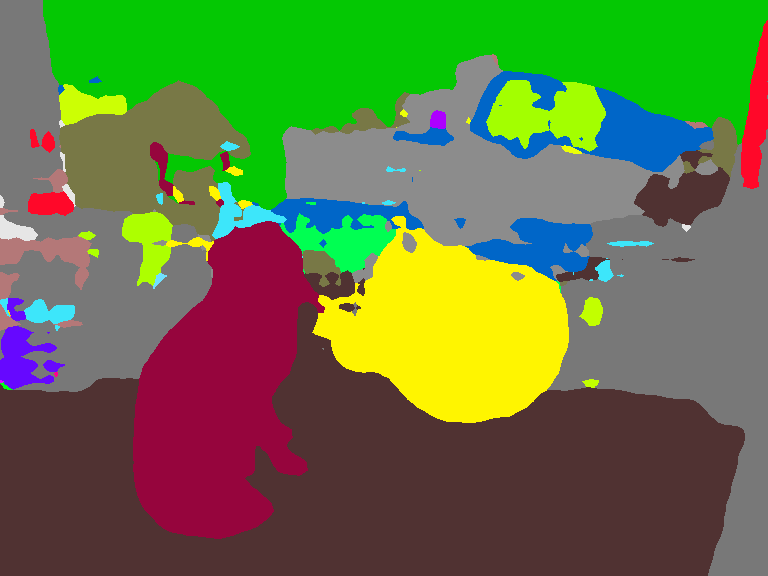

In [22]:
prediction_image = get_color_pallete(prediction, 'ade20k') # preset color mapping
prediction_image # i